# notebook to run a simple glm for shot change or optic flow from the budapest movie

## first run one subject one run

In [1]:
import numpy as np
import pandas as pd
import nibabel as nb
import hrf_tools
import hcp_utils as hcp
from analysis import plot_results
from os import walk
from nilearn.image import load_img

import matplotlib.pyplot as plt

/opt/miniconda-latest/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
flow = np.load(f'../sourcedata/data/budapest/features/budapest1_optic_flow_10hz.npy')

In [5]:
flow.shape
X = np.expand_dims(flow, axis=1)
X_hrf=hrf_tools.apply_optimal_hrf_10hz(X,10)

Text(0.5, 0, 'tr')

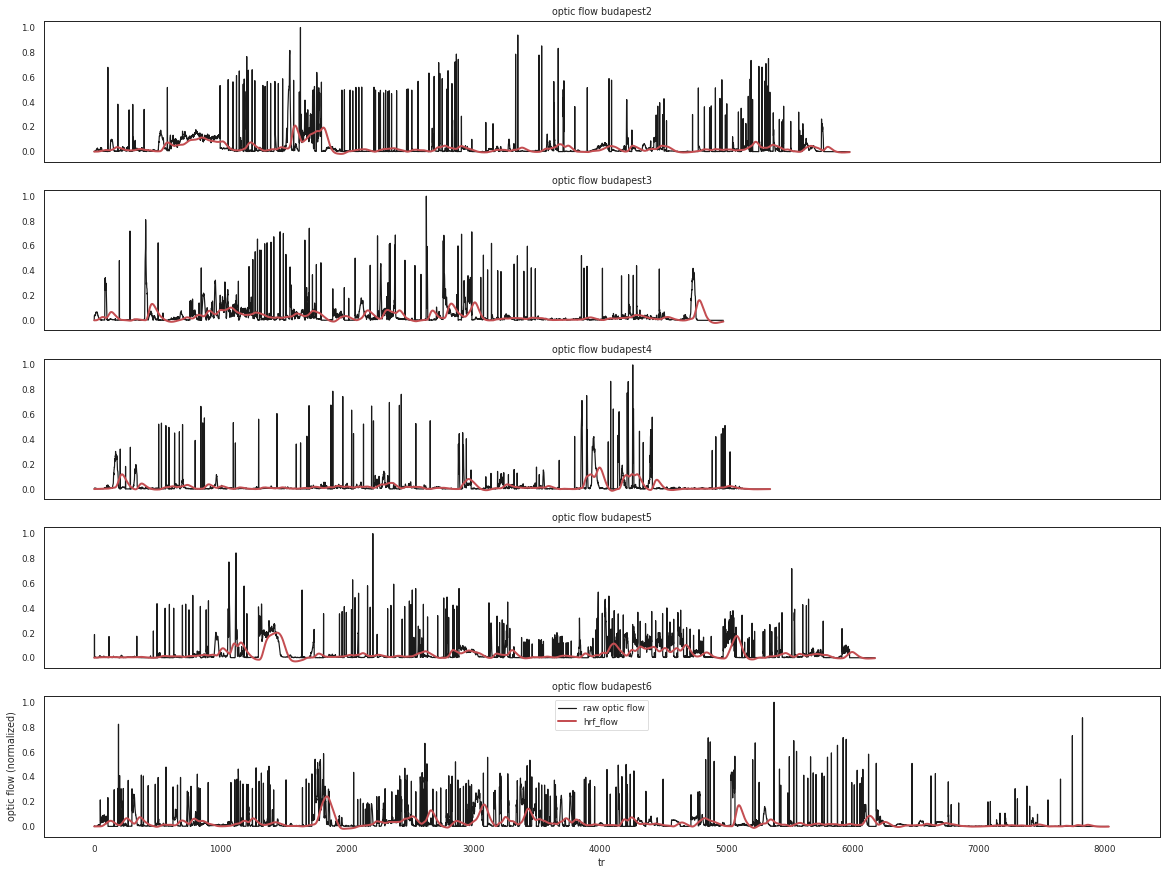

In [6]:
import hrf_tools
#plt.figure(figsize=(20,15))
# Share a Y axis with each row of subplots
fig, axs = plt.subplots(5, sharex=True, sharey=True,figsize=(20,15))
#fig.suptitle('Sharing both axes')
# axs[0].plot(x, y ** 2)
# axs[1].plot(x, 0.3 * y, 'o')
# axs[2].plot(x, y, '+')
for i in np.arange(1,6):
    X = np.load(f'../sourcedata/data/budapest/features/budapest{i}_optic_flow_10hz.npy')
    X = np.expand_dims(X, axis=1)
    axs[i-1].plot(X, label=f'raw optic flow', color = 'k')
    X_hrf=hrf_tools.apply_optimal_hrf_10hz(X,10)
    axs[i-1].plot(X_hrf, label=f'hrf_flow', color='r', linewidth=2)
    plt.ylabel(f'optic flow (normalized)')
    axs[i-1].set_title(f'optic flow budapest{str(i+1)}')
plt.legend()
#plt.title('raw rms')
plt.xlabel('tr')


In [7]:

im_file = f'../sourcedata/data/budapest/brain/ds003017/derivatives/fmriprep/derivatives/cleaned/smoothed/sub-sid000005_run1_clean_smooth_space-fsLR_den-91k_bold.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y = img_y

In [8]:
Y.shape

(598, 91282)

In [57]:
X = np.load(f'../sourcedata/data/budapest/features/budapest1_optic_flow_10hz.npy')
X = np.roll(X, 100) #shift everything 10s because the first and last 10 seconds were fixation not included in the stimulus.
#X = np.convolve(X,[1,1,1,1])
X = np.expand_dims(X, axis=1)
X = hrf_tools.apply_optimal_hrf_10hz(X,10)
X = hrf_tools.resample_1hz(X)
X = X[:Y.shape[0],:] # if it has one extra value
X = X[:Y.shape[0],:] # if it has one extra value

#X = np.hstack((X,X_n))

n_scans = Y.shape[0]
frame_times= np.arange(n_scans)

from nilearn.glm.first_level import make_first_level_design_matrix
design_matrix = make_first_level_design_matrix(frame_times, None,
                          add_regs=X, hrf_model=None, drift_model=None)

from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)

from nilearn.glm.first_level import run_glm
labels,results = run_glm(Y,design_matrix.values)



In [63]:
from nilearn.glm.contrasts import compute_contrast
contrast = compute_contrast(labels=labels, \
                            regression_result=results, \
                            con_val=np.array([1,0]).T, \
                            contrast_type='t')
vertex_info = hcp.get_HCP_vertex_info(img)
#from analysis import plot_59k_results
#plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
#plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')

subject='sid000005'
feature='optic_flow'
dataset='budapest'
title='glmtest'

plot_results(contrast.z_score(),'z','32k',vertex_info,subject,feature,dataset,title)

## run everyone

In [3]:
flow_list = []
for r in np.arange(1,6):
    flow = np.load(f'../sourcedata/data/budapest/features/budapest{r}_optic_flow_10hz.npy')
    flow_list.append(flow)

In [ ]:
import os
import gc
clean_path = '/nobackup/scratch/Mon/jsmentch/nat_img/sourcedata/data/budapest/brain/ds003017/derivatives/fmriprep/derivatives/cleaned/smoothed/'
subject_flist = list(walk(clean_path))[0][2:][0]
#all_=[]
for s in subject_flist:
    sub = s[0:13]
    run = s[17]
    #if not os.path.isfile(f'../outputs/figures/budapest/part{run}_GLM_{sub}_optic_flow_z.png'):    
    print(f'working on sub {sub} run {run}')
    subject=sub
    feature='optic_flow'
    dataset='budapest'
    title=f'part{run}_GLM'
    flow = flow_list[int(run)-1]
    img = load_img(f'{clean_path}{s}')
    Y = img.get_fdata()
    #img_data[np.isnan(img_data)] = 0
    X = np.load(f'../sourcedata/data/budapest/features/budapest{run}_optic_flow_10hz.npy')
    X = np.roll(X, 100) #shift everything 10s because the first and last 10 seconds were fixation not included in the stimulus.
    #X = np.convolve(X,[1,1,1,1])
    X = np.expand_dims(X, axis=1)
    X = hrf_tools.apply_optimal_hrf_10hz(X,10)
    X = hrf_tools.resample_1hz(X)
    X = X[:Y.shape[0],:] # if it has one extra value
    X = X[:Y.shape[0],:] # if it has one extra value

    #X = np.hstack((X,X_n))

    n_scans = Y.shape[0]
    frame_times= np.arange(n_scans)

    from nilearn.glm.first_level import make_first_level_design_matrix
    design_matrix = make_first_level_design_matrix(frame_times, None,
                              add_regs=X, hrf_model=None, drift_model=None)

    from nilearn.plotting import plot_design_matrix
    plot_design_matrix(design_matrix)

    from nilearn.glm.first_level import run_glm
    labels,results = run_glm(Y,design_matrix.values)

    from nilearn.glm.contrasts import compute_contrast
    contrast = compute_contrast(labels=labels, \
                                regression_result=results, \
                                con_val=np.array([1,0]).T, \
                                contrast_type='t')
    vertex_info = hcp.get_HCP_vertex_info(img)
    #from analysis import plot_59k_results
    #plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
    #plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')

    plot_results(contrast.z_score(),'z','32k',vertex_info,subject,feature,dataset,title)
    #all_.append(contrast.z_score())
    np.save(f'../outputs/glm/budapest/optic_flow/{sub}_part{run}',contrast.z_score())
    gc.collect()


## Make a mean plot

In [6]:
clean_path = '/nobackup/scratch/Mon/jsmentch/nat_img/outputs/glm/budapest/optic_flow/'
flist = list(walk(clean_path))[0][2:][0]
#all_=[]
all_sub = []
for s in flist:
    cur = np.load(f'{clean_path}{s}')
    all_sub.append(cur)
    

In [9]:
all_sub = np.array(all_sub)

In [12]:
all_sub_mean = np.mean(all_sub,axis=0)

In [14]:
all_sub_mean

(91282,)

In [15]:
plot_results(all_sub_mean,'z','32k',vertex_info,"all",feature,dataset,'partALL_GLM')

/nobackup/scratch/Mon/jsmentch/nat_img/code/nilearn_plotting_custom.py:184: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(figure, rect=[0, 0, 1, 1],


[0.31418681 0.31720168 0.31752112 ...        nan        nan        nan]
[0.31780772 0.3206409  0.32107682 ...        nan        nan        nan]
[0.31418681 0.31720168 0.31752112 ...        nan        nan        nan]
[0.31780772 0.3206409  0.32107682 ...        nan        nan        nan]


## Now run for shot_change

In [4]:
shot_list = []
for r in np.arange(1,6):
    shot = pd.read_csv(f'../sourcedata/data/budapest/features/shot_change_budapest{r}.tsv', sep='\t')
    shot = shot.value
    shot_list.append(shot)

In [7]:
a = [1,2,3,4,5]
np.pad(a,3)

array([0, 0, 0, 1, 2, 3, 4, 5, 0, 0, 0])

In [5]:
for s in shot_list:
    print(s.shape)

(5773,)
(4979,)
(5349,)
(6179,)
(8029,)


In [ ]:
import os
import gc
clean_path = '/nobackup/scratch/Mon/jsmentch/nat_img/sourcedata/data/budapest/brain/ds003017/derivatives/fmriprep/derivatives/cleaned/smoothed/'
subject_flist = list(walk(clean_path))[0][2:][0]
#all_=[]
for s in subject_flist:
    sub = s[0:13]
    run = s[17]
    #if not os.path.isfile(f'../outputs/figures/budapest/part{run}_GLM_{sub}_optic_flow_z.png'):    
    print(f'working on sub {sub} run {run}')
    subject=sub
    feature='shot_change'
    dataset='budapest'
    title=f'part{run}_GLM'
    shot = shot_list[int(run)-1]
    img = load_img(f'{clean_path}{s}')
    Y = img.get_fdata()
    #img_data[np.isnan(img_data)] = 0
    X = np.array(shot)
    X = np.pad(X, 100) #shift everything 10s because the first and last 10 seconds were fixation not included in the stimulus.
    #X = np.convolve(X,[1,1,1,1])
    X = np.expand_dims(X, axis=1)
    X = hrf_tools.apply_optimal_hrf_10hz(X,10)
    X = hrf_tools.resample_1hz(X)
    X = X[:Y.shape[0],:] # if it has one extra value
    X = X[:Y.shape[0],:] # if it has one extra value

    #X = np.hstack((X,X_n))

    n_scans = Y.shape[0]
    frame_times= np.arange(n_scans)

    from nilearn.glm.first_level import make_first_level_design_matrix
    design_matrix = make_first_level_design_matrix(frame_times, None,
                              add_regs=X, hrf_model=None, drift_model=None)

    from nilearn.plotting import plot_design_matrix
    plot_design_matrix(design_matrix)

    from nilearn.glm.first_level import run_glm
    labels,results = run_glm(Y,design_matrix.values)

    from nilearn.glm.contrasts import compute_contrast
    contrast = compute_contrast(labels=labels, \
                                regression_result=results, \
                                con_val=np.array([1,0]).T, \
                                contrast_type='t')
    vertex_info = hcp.get_HCP_vertex_info(img)
    #from analysis import plot_59k_results
    #plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
    #plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')

    plot_results(contrast.z_score(),'z','32k',vertex_info,subject,feature,dataset,title)
    #all_.append(contrast.z_score())
    np.save(f'../outputs/glm/budapest/shot_change/{sub}_part{run}',contrast.z_score())
    gc.collect()


working on sub sub-sid000055 run 1


/opt/miniconda-latest/lib/python3.8/site-packages/nilearn/_utils/glm.py:306: RuntimeWarning: divide by zero encountered in double_scalars
  cond = smax / smin
/opt/miniconda-latest/lib/python3.8/site-packages/nilearn/_utils/glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
/nobackup/scratch/Mon/jsmentch/nat_img/code/nilearn_plotting_custom.py:184: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(figure, rect=[0, 0, 1, 1],


[0.06734897 0.0759369  0.08159953 ...        nan        nan        nan]
[0.01095906 0.0134435  0.01366939 ...        nan        nan        nan]
[0.06734897 0.0759369  0.08159953 ...        nan        nan        nan]
[0.01095906 0.0134435  0.01366939 ...        nan        nan        nan]
working on sub sub-sid000535 run 1
[0.05555615 0.05598836 0.05642575 ...        nan        nan        nan]
[0.1001071  0.10088943 0.10099612 ...        nan        nan        nan]
[0.05555615 0.05598836 0.05642575 ...        nan        nan        nan]
[0.1001071  0.10088943 0.10099612 ...        nan        nan        nan]
working on sub sub-sid000020 run 4
[0.08094492 0.09201565 0.09328295 ...        nan        nan        nan]
[0.05252237 0.0536881  0.05395549 ...        nan        nan        nan]
[0.08094492 0.09201565 0.09328295 ...        nan        nan        nan]
[0.05252237 0.0536881  0.05395549 ...        nan        nan        nan]
working on sub sub-sid000013 run 3
[0.23642347 0.2379252  0.239711